### based on https://github.com/higgsfield/RL-Adventure and https://medium.com/swlh/introduction-to-reinforcement-learning-coding-sarsa-part-4-2d64d6e37617

In [1]:
%matplotlib inline
import collections
import cv2
import gym
import matplotlib.pyplot as plot
import numpy as np
import random
import time
import torch as t
from IPython.display import clear_output

In [2]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not belive how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]))

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = collections.deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]))

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(ResizeObservation, self).__init__(env)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0] // 2, shp[1] // 2, shp[2]))
        self.resize_to = (shp[1] // 2, shp[0] // 2)

    def observation(self, observation):
        return cv2.resize(observation, self.resize_to, interpolation=cv2.INTER_AREA)

env = gym.make('PongDeterministic-v4')
env = ResizeObservation(env)
env = ImageToPyTorch(env)
env = FrameStack(env, 4)

In [3]:
USE_CUDA = t.cuda.is_available()# and False
device = t.device('cuda') if USE_CUDA else t.device('cpu')

In [4]:
class Actor(object):
    def __init__(self, env, model, eps, eps_final, eps_steps, initial_explore=0):
        self.env = env
        self.model = model
        self.eps = eps
        self.eps_final = eps_final
        self.eps_decay = np.exp(np.log(eps_final / eps) / eps_steps)
        self.initial_explore = initial_explore
    
    def act(self, state):
        if self.initial_explore > 0:
            self.initial_explore -= 1
            return self.env.action_space.sample()
        self.eps = max(self.eps_final, self.eps * self.eps_decay)
        if random.random() < self.eps:
            return self.env.action_space.sample()
        state = t.FloatTensor(np.array(state)).to(device)
        q = self.model(state)
        return q.argmax().item()

In [ ]:
class NoisyLinear(t.nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = t.nn.Parameter(t.FloatTensor(out_features, in_features))
        self.weight_sigma = t.nn.Parameter(t.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', t.FloatTensor(out_features, in_features))
        
        self.bias_mu    = t.nn.Parameter(t.FloatTensor(out_features))
        self.bias_sigma = t.nn.Parameter(t.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', t.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias   = self.bias_mu   + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return t.nn.functional.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = t.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

In [ ]:
class Model(t.nn.Module):
    def __init__(self, input_shape, n_out):
        super().__init__()
        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(12, 32, kernel_size=8, stride=4),            t.nn.PReLU(),
            t.nn.Conv2d(32, 64, kernel_size=4, stride=2),            t.nn.PReLU(),
            t.nn.Conv2d(64, 64, kernel_size=3, stride=1),            t.nn.PReLU(),
        ) # -> 64 9 6
        self.fc = t.nn.Sequential(
            NoisyLinear(self.feature_size(input_shape), 512),        t.nn.PReLU(),
            t.nn.Linear(512, n_out)
        )
    
    def feature_size(self, input_shape):
        return self.cnn(t.zeros(1, *input_shape)).view(1, -1).size(1)

    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        p = self.cnn(x)
        p = p.view(p.size(0), -1)
        return self.fc(p)

In [ ]:
class Replay(object):
    def __init__(self, maxlen):
        self.memory = collections.deque(maxlen=maxlen)
    def __len__(self):
        return len(self.memory)
    def add(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))
    def sample(self, n):
        with t.no_grad():
            states, actions, next_states, rewards, masks = zip(*random.choices(self.memory, k=n))
            actions = t.LongTensor(actions).to(device)
            rewards = t.FloatTensor(rewards).to(device)
            masks = 1 - t.FloatTensor(masks).to(device)
            states = Replay.stack_states(states)
            next_states = Replay.stack_states(next_states)
            return states, actions, next_states, rewards, masks
    @staticmethod
    def stack_states(states):
        s = np.concatenate([np.expand_dims(x, 0) for x in states])
        return t.ByteTensor(s).to(device).float()

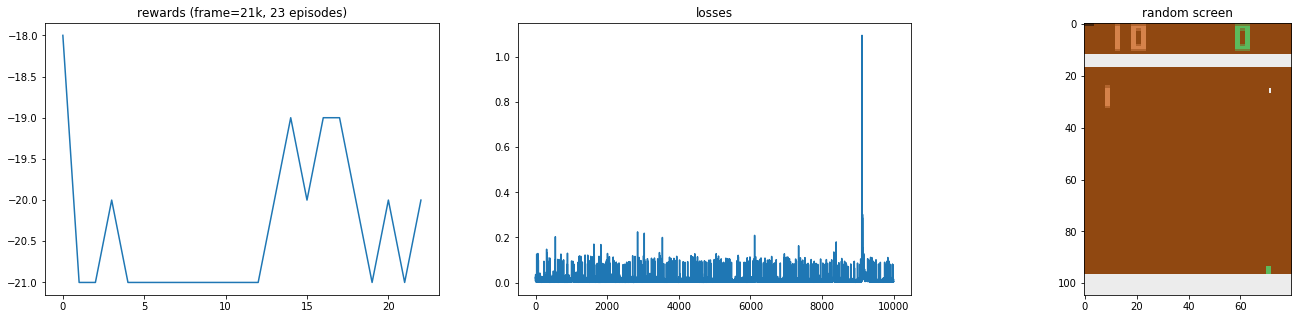

In [ ]:
def build_model():
    return Model(env.observation_space.shape, env.action_space.n).to(device)

def reset_env(env):
    state = env.reset()
    if 'FIRE' in env.unwrapped.get_action_meanings():
        state, _, _, _ = env.step(env.unwrapped.get_action_meanings().index('FIRE'))
    return state

def plot_state():
    clear_output(False)
    plot.figure(figsize=(24,5))
    plot.subplot(131)
    plot.title('rewards (frame=%dk, %d episodes)' % (np.round(frame/1000), episode))
    plot.plot(all_rewards[:-1])
    plot.subplot(132)
    plot.title('losses')
    plot.plot(losses)
    plot.subplot(133)
    plot.title('random screen')
    state, _, _, _, _ = replay.sample(1)
    plot.imshow(state.squeeze(0)[-3:].permute(1, 2, 0).cpu().numpy() / 255)
    plot.show();

def learn_on_replay():
    states, actions, next_states, rewards, masks = replay.sample(batch_size)
    
    q_values = model(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    
    q_next_values = target_model(next_states)
    q_next_value = q_next_values.max(1).values

    target = rewards + gamma * masks * q_next_value
    loss = loss_fn(q_value, target.detach())

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())
    
DOUBLE_MODEL = True
model = build_model()
target_model = build_model() if DOUBLE_MODEL else model
opt =  t.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = t.nn.SmoothL1Loss()

replay = Replay(1000000)
actor = Actor(env, model, 1, 0.05, 50000, 0)
all_rewards = []
losses = collections.deque(maxlen=10000)
batch_size = 32
gamma = 0.99
frame = 0

for episode in range(10000):
    all_rewards.append(0)
    state, done = reset_env(env), False
    while not done:
        frame += 1
        action = actor.act(state)
        next_state, reward, done, info = env.step(action)
        all_rewards[-1] += reward
        replay.add(state, action, next_state, reward, done)
        state = next_state

        if len(replay) > 10000:
            learn_on_replay()
        
        if DOUBLE_MODEL and (frame % 1000 == 0):
            target_model.load_state_dict(model.state_dict())
        
        if frame % 1000 == 0:
            plot_state()

    if len(all_rewards) > 100 and np.mean(all_rewards[-100:]) > 18:
        break

plot_state()

In [ ]:
import gzip
with gzip.open('model-pong-noisy-dqn.gz', 'wb') as f:
    t.save(model.state_dict(), f, pickle_protocol=4)

In [ ]:
env = gym.make('PongDeterministic-v4')
env = gym.wrappers.Monitor(env, '.', force=True)
env = ResizeObservation(env)
env = ImageToPyTorch(env)
env = FrameStack(env, 4)

state, done = env.reset(), False
while not done:
    state = t.FloatTensor(np.array(state)).to(device)
    action = model(state).argmax().item()
    state, _, done, _ = env.step(action)

env.close()
!ls -lh